### Attention model of cued similarity
- See
    - [perceptual magnet model viz](https://github.com/timsainb/CDCP_paper/blob/01_02_22/notebooks_clean/01_02_22/01_bayesian_model/perceptual-magnet-effect-visualizations.ipynb)
    - [similarity matrix results](https://github.com/timsainb/CDCP_paper/blob/03_17_23/notebooks_clean/01_02_22/10_cued_similarity/analyze-sm-between-cue-and-within.ipynb)
    
- model assumptions
    - We treat the data as having two components for variation
        1. Stimulus-relevant variation
        2. Stimulus irrelevant variation
    - We treat these as two orthogonal dimensions in stimulus space 
    - We treat the noise in perception as being zero-sum: if we attend to one dimension of the signal space, noise in the other dimension will increase
- model description
    - for each prior probability condition
        - for each stimulus
            - compute the likelihood in the stimulus-relevant dimension
            - compute the likelihood in the stimulus irrelevant dimension
            - (in each case as a gaussian modulated by prior)
    - sample *n* points from these distributions
    - compute similarity matrix as average between points for each stimulus relevant bin 
    - compare similarity matrices between cue conditions

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

pd.set_option("display.max_columns", 500)
import seaborn as sns
from cdcp.visualization.colors import colors as cdcp_colors
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

%matplotlib inline

In [37]:
from pathlib import Path

In [38]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

In [39]:
save_figs=True

In [40]:
def gaussian(x, mu=0, sig=1):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sig, 2.0)))

### Parameters

In [41]:
probability_left_ranges = [0.125, 0.25, 0.5, 0.75, 0.875]
sigma_likelihood = 5
sigma_likelihood_irrelevant = 3

In [42]:
# decision 
x_true = np.arange(-100, 100)
half = int(len(x_true) / 2)
decision_boundary = np.concatenate([np.zeros(half), np.ones(half)])
bds = [half - 64, half + 64]
x_true_bds = [x_true[half] - 64, x_true[half] + 64]

n_samples_per_x_true = 200
irrelevant_multiplier = 5
n_repeats_posterior = 100 # 
n_repeats_likelihood = 1

In [43]:
# the 
point_indices = np.arange(len(x_true))

In [44]:
p_left = 0.25  # 0.875

In [45]:
from cdcp.behavior.psychometric import FourParameterLogistic

In [46]:
# example prior probability
smooth_prior = True
if smooth_prior == False:
    prior_probability = np.concatenate(
        [np.ones(half) * p_left, np.ones(half) * (1 - p_left)]
    )
else:
    prior_probability = FourParameterLogistic(
        p={
            "_min": p_left,
            "_max": 1 - p_left,
            "inflection": len(x_true) / 2,
            "slope": 50,
        },
        x=np.arange(len(x_true)),
    )
prior_probability = prior_probability / np.sum(prior_probability)

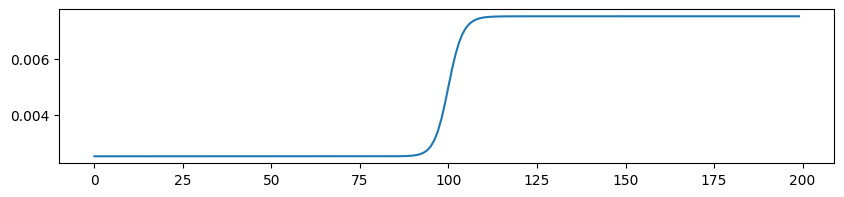

In [47]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(prior_probability)

In [48]:
from joblib import Parallel, delayed
import numpy as np

def compute_similarity(x_true, perceived, i, point_indices):
    xi = perceived[x_true == i]
    row = np.zeros(len(point_indices))
    for j in point_indices:
        if i > j:
            continue
        xj = perceived[x_true == j]
        sm = 1 / (1 + euclidean_distances(xi, xj))
        if i == j:
            sm = sm[np.tril_indices(len(sm), k=-1)]
        row[j] = np.mean(sm)
    return i, row

def compute_similarity_matrix(x_true, perceived, point_indices):
    mean_sm = np.zeros((len(point_indices), len(point_indices)))
    results = Parallel(n_jobs=-1)(delayed(compute_similarity)(x_true, perceived, i, point_indices) for i in (point_indices))
    for i, row in results:
        mean_sm[i, :] += row
        row[i] = 0
        mean_sm[:, i] += row
    return mean_sm

In [49]:
probability_left_ranges = [0.125, 0.25, 0.875, 0.75]

In [50]:
n_stim_irrelevant = 2

p(left)=0.125


100%|██████████| 1/1 [00:02<00:00,  2.79s/it]
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


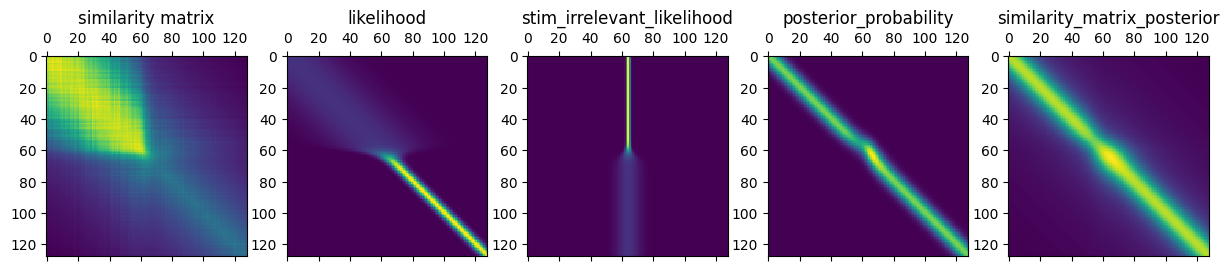

p(left)=0.25


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


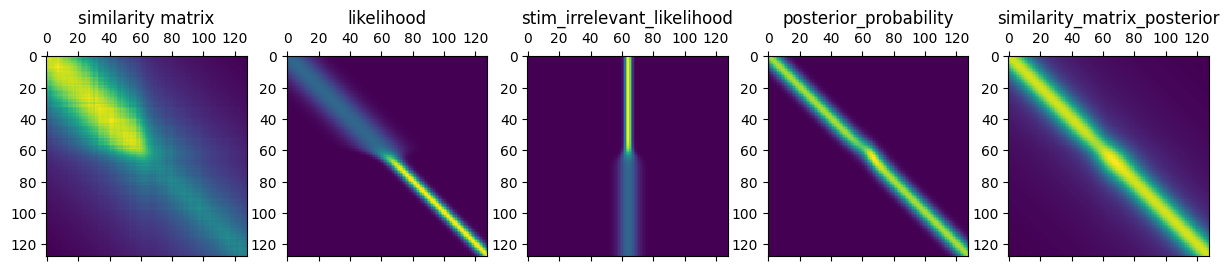

p(left)=0.875


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


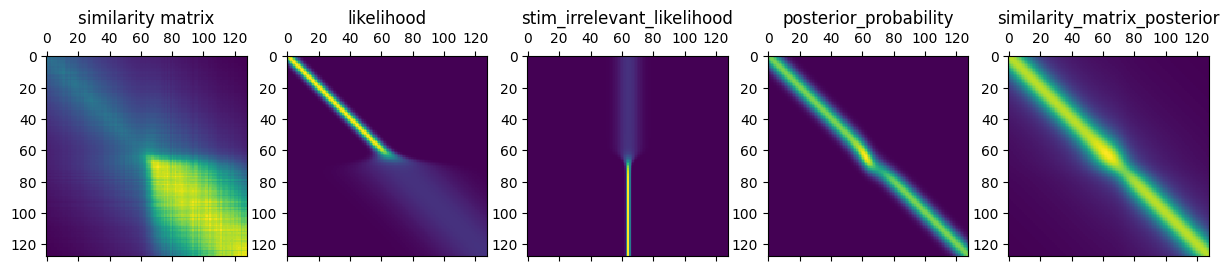

p(left)=0.75


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/groups/datta/tim_sainburg/conda_envs/cdcp_paper/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


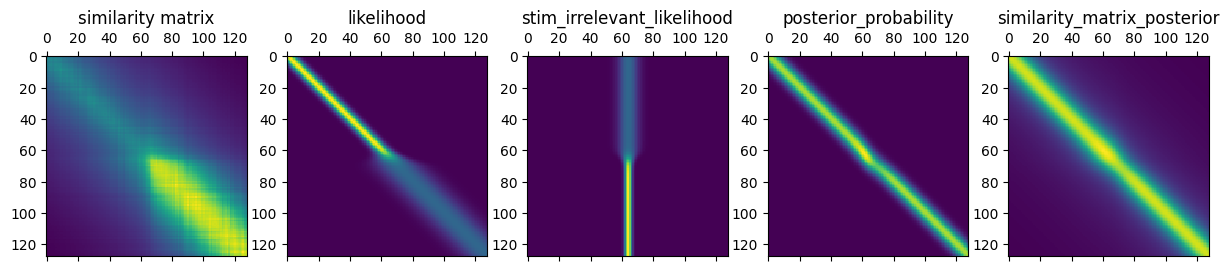

In [51]:
all_sample_dfs = []
prob_df = pd.DataFrame(
    columns=[
        "p_left",
        "prior_probability",
        "likelihood",
        "similarity_matrix",
        "posterior_probability",
        "similarity_matrix_posterior",
    ]
    + [f"stim_irrelevant_likelihood_{i}" for i in range(n_stim_irrelevant)],
)

for p_left in probability_left_ranges:
    
    # compute the prior
    print(f"p(left)={p_left}")
    if smooth_prior == False:
        prior_probability = np.concatenate(
            [np.ones(half) * p_left, np.ones(half) * (1 - p_left)]
        )
    else:
        prior_probability = FourParameterLogistic(
            p={
                "_min": p_left,
                "_max": 1 - p_left,
                "inflection": len(x_true) / 2,
                "slope": 50,
            },
            x=np.arange(len(x_true)),
        )
    prior_probability = prior_probability / np.sum(prior_probability)
    
    
    # compute the sigma of the likelihood, relative to the prior
    prior_sigma = [
        sigma_likelihood / (prior_i / (1 / len(prior_probability)))
        for prior_i in prior_probability
    ]
    
    # compute the liklihood
    unmodulated_likelihood = np.array(
        [gaussian(x_true, x_i, sigma_likelihood) for sig_i, x_i in zip(prior_sigma, x_true)]
    )
    unmodulated_likelihood = np.array(
        [i / np.sum(i) for i in unmodulated_likelihood]
    )  # normalize likelihood gaussian to sum to 1

    
    # compute the liklihood
    likelihood = np.array(
        [gaussian(x_true, x_i, sig_i) for sig_i, x_i in zip(prior_sigma, x_true)]
    )
    likelihood = np.array(
        [i / np.sum(i) for i in likelihood]
    )  # normalize likelihood gaussian to sum to 1

    # sample from the likelihood
    sample_relevant_true = np.concatenate(
        [np.repeat(i, n_samples_per_x_true) for i in point_indices]
    )

    # compute and sample from a second distribution inversely modulated by the prior probability
    stim_irrelevant_likelihoods = []
    for dim in range(n_stim_irrelevant):
        prior_sigma_irrelevant = [
            sigma_likelihood_irrelevant / ((1 / len(prior_probability)) / prior_i)
            for prior_i in prior_probability
        ]

        stim_irrelevant_likelihood = np.array(
            [
                gaussian(x_true, 0, sig_i)
                for sig_i, x_i in zip(prior_sigma_irrelevant, x_true)
            ]
        )

        stim_irrelevant_likelihood = np.array(
            [i / np.sum(i) for i in stim_irrelevant_likelihood]
        )  # normalize likelihood gaussian to sum to 1

        stim_irrelevant_likelihoods.append(stim_irrelevant_likelihood)
    
    similarity_matrix_list = []
    for i in tqdm(range((n_repeats_likelihood))):
        
        
        sample_relevant_perceived = np.concatenate(
            [
                np.random.choice(point_indices, size=n_samples_per_x_true, p=likelihood[i])
                for i in point_indices
            ]
        )
    
        

        sampless_irrelevant_perceived = []
        for dim in range(n_stim_irrelevant):
            sample_irrelevant_perceived = np.concatenate(
                [
                    irrelevant_multiplier
                    * np.random.choice(
                        point_indices,
                        size=n_samples_per_x_true,
                        p=stim_irrelevant_likelihood[i],
                    )
                    for i in point_indices
                ]
            )
            sampless_irrelevant_perceived.append(sample_irrelevant_perceived)

        # overall percieved is a combination of likelihood and stim irrelevant noise
        sample_perceived = np.stack(
            [sample_relevant_perceived] + sampless_irrelevant_perceived
        ).T


        # compute similarity of the percieved sample
        similarity_matrix = compute_similarity_matrix(
            sample_relevant_true, sample_perceived, point_indices
        )
    similarity_matrix_list = np.mean(similarity_matrix_list, axis=0)

    # calculate the posterior probability
    posterior_probability = unmodulated_likelihood * prior_probability
    
    posterior_probability = np.array(
        [i / np.sum(i) for i in posterior_probability]
    )  # normalize posterior probability to sum to 1
    
    # sample from posterior probability
    sample_posterior = np.concatenate(
        [
            np.random.choice(
                point_indices, size=n_samples_per_x_true, p=posterior_probability[i]
            )
            for i in point_indices
        ]
    )

    similarity_matrix_posterior_list = []
    # repeat measurements a few times without filling ram so model output will be
    #.  less noisy. 
    for i in tqdm(range((n_repeats_posterior))):
        # sample from posterior probability
        sample_posterior = np.concatenate(
            [
                np.random.choice(
                    point_indices,
                    size=n_samples_per_x_true,
                    p=posterior_probability[i],
                )
                for i in point_indices
            ]
        )

        # compute similarity
        similarity_matrix_posterior_list.append(
            compute_similarity_matrix(
                sample_relevant_true,
                np.expand_dims(sample_posterior, -1),
                point_indices,
            )
        )

    similarity_matrix_posterior = np.mean(similarity_matrix_posterior_list, axis=0)
    
    # plot results
    fig, axs = plt.subplots(ncols=5, figsize=(15, 5))
    ax = axs[0]
    ax.matshow(similarity_matrix[bds[0] : bds[1], bds[0] : bds[1]])
    ax.set_title("similarity matrix")

    ax = axs[1]
    ax.matshow(likelihood[bds[0] : bds[1], bds[0] : bds[1]])
    ax.set_title("likelihood")

    ax = axs[2]
    ax.matshow(stim_irrelevant_likelihood[bds[0] : bds[1], bds[0] : bds[1]])
    ax.set_title("stim_irrelevant_likelihood")

    ax = axs[3]
    ax.matshow(posterior_probability[bds[0] : bds[1], bds[0] : bds[1]])
    ax.set_title("posterior_probability")

    ax = axs[4]
    ax.matshow(similarity_matrix_posterior[bds[0] : bds[1], bds[0] : bds[1]])
    ax.set_title("similarity_matrix_posterior")
    plt.show()

    # add to dataframe
    prob_df.loc[len(prob_df)] = [
        p_left,
        prior_probability,
        likelihood,
        similarity_matrix,
        posterior_probability,
        similarity_matrix_posterior,
    ] + stim_irrelevant_likelihoods


    # save sample values
    true_x_vals = np.repeat(point_indices, n_samples_per_x_true)
    samples_df = pd.DataFrame([
        np.repeat(p_left, len(true_x_vals)), true_x_vals, sample_perceived, sample_posterior
    ]).T
    samples_df.columns = [
            "p_left",
            "true_x",
            "response_likelihood",
            "response_posterior",
        ]
    all_sample_dfs.append(samples_df)

### Save output

In [54]:
from cdcp.paths import DATA_DIR, ensure_dir

In [53]:
# create prediction dataframe
prediction_df = pd.concat(all_sample_dfs)

In [56]:
ensure_dir(DATA_DIR / 'similarity_shift_model')
prediction_df.to_pickle(DATA_DIR / 'similarity_shift_model' / 'prediction_df.pickle')

In [58]:
prob_df.to_pickle(DATA_DIR / 'similarity_shift_model' / 'prob_df.pickle')